In [1]:

from ND_path_finder.src.data_generators.perlin_generator import PerlinNoiseGenerator
from ND_path_finder.src.data_samplers.random_sampler import sample_xarray
from ND_path_finder.src.edge_detection.SVM_2D_contour import svm_boundary_2D

In [2]:
# Initialize the generator with 2D resolution
generator_2D = PerlinNoiseGenerator(res=[100, 100], octv=3, seed=42, time_test=False)

# Generate Perlin noise data
xdataset_2D = generator_2D.perlin_data_xarray()

# generator.plot_2D_xarray()


In [3]:
xdataset_2D

<xarray.Dataset> Size: 200kB
Dimensions:       (points: 10000, dim: 2)
Coordinates:
    points        (points, dim) float64 160kB 0.0 0.0 0.0 ... 0.9899 1.0 1.0
Dimensions without coordinates: dim
Data variables:
    noise_values  (points) int32 40kB 1 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 0 1
Attributes:
    octaves:     3
    resolution:  [100, 100]
    dimensions:  2

In [4]:
# Initialize the generator with 2D resolution
generator_3D = PerlinNoiseGenerator(res=[30, 30, 30], octv=3, seed=47, time_test=False)

# Generate Perlin noise data
xdataset_3D = generator_3D.perlin_data_xarray()

# generator.plot_2D_xarray()


In [5]:
xdataset_3D

<xarray.Dataset> Size: 756kB
Dimensions:       (points: 27000, dim: 3)
Coordinates:
    points        (points, dim) float64 648kB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0
Dimensions without coordinates: dim
Data variables:
    noise_values  (points) int32 108kB 1 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1
Attributes:
    octaves:     3
    resolution:  [30, 30, 30]
    dimensions:  3

Best parameters: {'C': 100, 'gamma': 50}


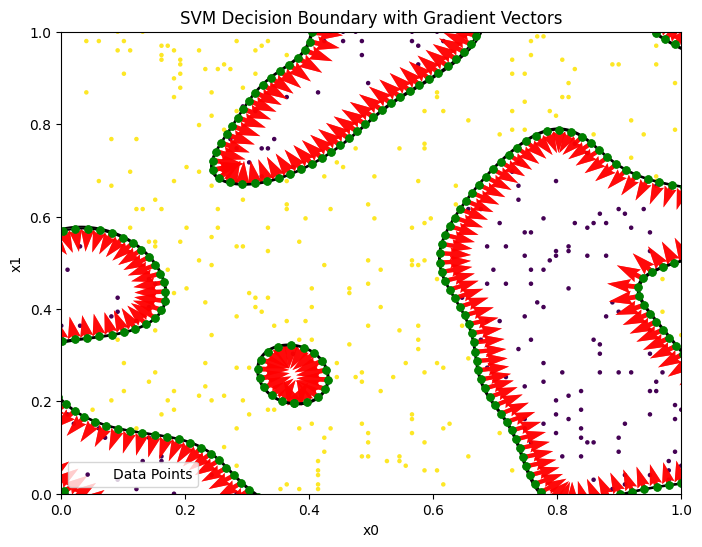

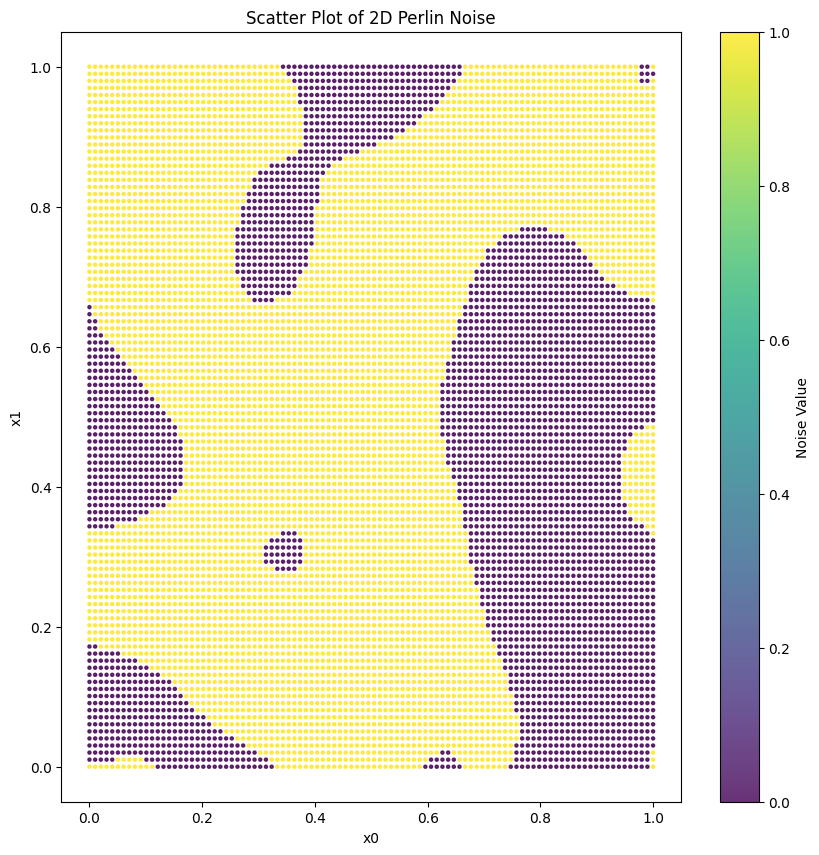

In [6]:
svm_boundary_2D(sample_xarray(xdataset_2D, 400), boundary_resolution_len=0.02, plot=True)

generator_2D.plot_2D_xarray()

# 3D case

In [7]:
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import GridSearchCV
from scipy.interpolate import griddata
from scipy.spatial.distance import pdist, squareform
from numpy.linalg import norm

import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


def boundary_from_contour_with_gradients_ND(grid_coords, Z, boundary_resolution_len):
    """
    Extract boundary points and gradients for N-dimensional data.

    Parameters:
    - grid_coords: List of arrays for each dimension (e.g., [x, y] for 2D, [x, y, z] for 3D).
    - Z: Decision function values on the grid.
    - boundary_resolution_len: Spacing between boundary points.

    Returns:
    - all_interpolated_points: List of arrays of interpolated boundary points.
    - all_gradients: List of arrays of gradient vectors at the boundary points.
    """
    Z_smoothed = gaussian_filter(Z, sigma=1)  # Smooth the decision function for stability

    # Find boundary points where the decision function crosses zero
    boundary_mask = np.abs(Z_smoothed) < 1e-2
    boundary_indices = np.array(np.nonzero(boundary_mask)).T


    # print(boundary_indices)

    # # Map indices to real coordinates
    # all_interpolated_points = []
    # all_gradients = []

    # # Step size for each dimension
    # step_sizes = [grid_coords[dim][1] - grid_coords[dim][0] for dim in range(len(grid_coords))]

    # for index_set in boundary_indices:
    #     point_coords = np.array([grid_coords[dim][index] for dim, index in enumerate(index_set)])
    #     all_interpolated_points.append(point_coords)

    #     # Compute gradient using finite differences
    #     gradients = np.zeros(len(grid_coords))
    #     for dim in range(len(grid_coords)):
    #         shifted_index_forward = np.array(index_set, dtype=int)
    #         shifted_index_backward = np.array(index_set, dtype=int)

    #         # Handle boundary conditions
    #         shifted_index_forward[dim] = min(index_set[dim] + 1, Z.shape[dim] - 1)
    #         shifted_index_backward[dim] = max(index_set[dim] - 1, 0)

    #         forward_val = Z[tuple(shifted_index_forward)]
    #         backward_val = Z[tuple(shifted_index_backward)]
    #         gradients[dim] = (forward_val - backward_val) / step_sizes[dim]

    #     gradients /= np.linalg.norm(gradients)  # Normalize
    #     all_gradients.append(gradients)

    # return np.array(all_interpolated_points), np.array(all_gradients)




def svm_boundary_from_xarray_ND(dataset, boundary_resolution_len=0.5, boundary_mesh_resolution=100):
    """
    Fits an SVM model to the data in an xarray.Dataset and extracts the N-dimensional decision boundary.

    Parameters:
    - dataset (xarray.Dataset): The input dataset containing 'points' and 'noise_values'.
    - boundary_resolution_len: Distance between points in the extracted boundary.
    - boundary_mesh_resolution: Number of points per dimension in the grid for evaluation.

    Returns:
    - interp_boundary_points: Interpolated boundary points.
    - boundary_gradients: Gradient vectors at the boundary points.
    """
    if not {'points', 'noise_values'}.issubset(dataset.variables):
        raise ValueError("Dataset must contain 'points' and 'noise_values' variables.")

    # Extract features and labels
    X = dataset['points'].values  # Shape (num_points, dim)
    y = dataset['noise_values'].values  # Shape (num_points,)

    # Define the parameter grid for grid search
    param_grid = {
        'C': [0.01, 0.1, 1, 10],
        'gamma': [0.001, 0.01, 0.1, 1]
    }

    # Perform grid search to find the best parameters
    svc = SVC(kernel='rbf')
    grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X, y)

    best_svm = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")

    # Create a grid for decision function evaluation
    dims = X.shape[1]
    grid_ranges = [np.linspace(X[:, dim].min(), X[:, dim].max(), boundary_mesh_resolution) for dim in range(dims)]
    grid_coords = np.meshgrid(*grid_ranges, indexing='ij')
    grid_points = np.vstack([g.ravel() for g in grid_coords]).T

    Z = best_svm.decision_function(grid_points)
    Z = Z.reshape([len(r) for r in grid_ranges])




    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, boundary_mesh_resolution),
                        np.linspace(y_min, y_max, boundary_mesh_resolution))


    print(Z.shape)
    # plt.imshow(Z)
    # plt.contour(xx, yy, Z, levels=[-1,0,1], linestyles=['-'], colors='k')



    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=5, label="Data Points")

    # Extract boundary points and gradients
    # interp_boundary_points, boundary_gradients = boundary_from_contour_with_gradients_ND(grid_coords, Z, boundary_resolution_len)

    # return interp_boundary_points, boundary_gradients


In [8]:
svm_boundary_from_xarray_ND(sample_xarray(xdataset_2D, 100), boundary_resolution_len=0.02)


Best parameters: {'C': 10, 'gamma': 1}
(100, 100)


NameError: name 'plt' is not defined

In [10]:
svm_boundary_from_xarray_ND(sample_xarray(xdataset_3D, 400), boundary_resolution_len=0.02)


Best parameters: {'C': 1, 'gamma': 1}
(100, 100, 100)


In [11]:
# Plot the identified boundaries
# SVMBoundary(sample_xarray(xdataset_2D, 1000)).plot_traversed_boundaries()